In [5]:
import matplotlib.pyplot as plt
plt.rcParams.update({"figure.facecolor":  (1.0, 1.0, 1.0, 1), "svg.fonttype": "none"})
import xarray as xr
import numpy as np

# path to files
in_dh_1 = "./data/dh1.tif" # raster 1 (e.g. elevation difference dh)
in_dh_2 = "./data/dh2.tif" # raster 2 (e.g. elevation difference dh)
in_dem = "./data/dem.tif" # elevation raster
in_asp = "./data/asp.tif" # aspect raster
in_slp = "./data/slp.tif" # slope raster

# nice color shade at https://digitalsynopsis.com/design/beautiful-color-palettes-combinations-schemes/
c1="#fe4a49"
c2="#2ab7ca"
inch2cm=1/2.54 # convert inch to cm, used to set size of figure
    
def get_group_values( data_grouped, n_min ):
    # function to read the values from a grouped xr.DataArray 
    # removing nan values and groups containing less than n_min elements
    boxplot_data, bin2plot = [], []
    for name, group in data_grouped:
        gg_val = group.values
        gg_val = gg_val[~np.isnan(gg_val)]
        if len(gg_val) > n_min: # if group size larger than n_min
            boxplot_data.append(gg_val)
        else: # not enough data
            boxplot_data.append([])
        bin2plot.append(name.mid)
    return boxplot_data, bin2plot

In [6]:
# Read data
dem = xr.open_rasterio(in_dem).squeeze("band")
dem = dem.where(dem != dem.nodatavals[0], np.nan) # set no-data values to nan
pixel_area_km2 = abs((dem.y[1].values-dem.y[0].values)*(dem.x[1].values-dem.x[0].values))/1e6

asp = xr.open_rasterio(in_asp).squeeze("band")
asp = asp.where(asp != asp.nodatavals[0], np.nan) # set no-data values to nan

slp = xr.open_rasterio(in_slp).squeeze("band")
slp = slp.where(slp != slp.nodatavals[0], np.nan) # set no-data values to nan

dh_1 = xr.open_rasterio(in_dh_1).squeeze("band")
dh_1 = dh_1.assign_coords(Z=dem) # add elevation as a coordinate of the DataArray
dh_1 = dh_1.assign_coords(ASP=asp) # add aspect as a coordinate of the DataArray
dh_1 = dh_1.assign_coords(SLP=slp) # add slope as a coordinate of the DataArray
dh_1 = dh_1.where(dh_1 != dh_1.nodatavals[0], np.nan) # set no-data values to nan

dh_2 = xr.open_rasterio(in_dh_2).squeeze("band")
dh_2 = dh_2.assign_coords(Z=dem)
dh_2 = dh_2.assign_coords(ASP=asp)
dh_2 = dh_2.assign_coords(SLP=slp)
dh_2 = dh_2.where(dh_2 != dh_2.nodatavals[0], np.nan) # set no-data values to nan


/tmp/ipykernel_47209/876953546.py:2: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  dem = xr.open_rasterio(in_dem).squeeze("band")
/tmp/ipykernel_47209/876953546.py:6: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  asp = xr.open_rasterio(in_asp).squeeze("band")
/tmp/ipykernel_47209/876953546.py:9: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  slp = xr.open_rasterio(in_slp).squeeze("band")
/tmp/ipykernel_47209/876953546.py:12: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://cort

/tmp/ipykernel_47209/2368851071.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


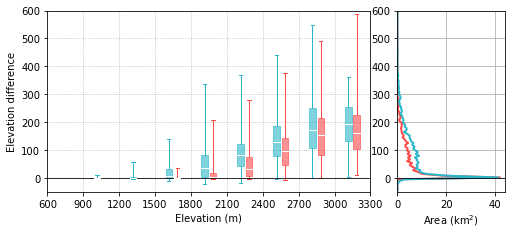

In [7]:
bin_elev_edges = np.arange(600,3600,300)
n_min = 30 # minimum number of element per group
# Create the figure
fig = plt.figure(figsize=(19*inch2cm, 8*inch2cm))

########################
# Create the left plot - raster = f(elevation)
ax = fig.add_axes([0.1, 0.1, 0.6, 0.8])  # [left, bottom, width, height]

# dh_1
data_grouped = dh_1.groupby_bins( 'Z', bin_elev_edges)
boxplot_data, bin2plot = get_group_values( data_grouped, n_min )

# Create the boxplot
# whis controls the extent of the whiskers, (0,100) shows the min-max extent
bp_0 = ax.boxplot(boxplot_data, positions=np.array(bin2plot)+35, widths=55, patch_artist=True, whis= (0, 100), showfliers=False,
            boxprops = { "facecolor":c1, "color":c1, "alpha":0.6},
            capprops = { "color":c1},
            whiskerprops = { "color":c1},
            medianprops = { "color":"w"},
            )

# dh_2
data_grouped = dh_2.groupby_bins( 'Z', bin_elev_edges)
boxplot_data, bin2plot = get_group_values( data_grouped, n_min )

# Create the boxplot
bp_1 = ax.boxplot(boxplot_data, positions=np.array(bin2plot)-35, widths=55, patch_artist=True, whis=(0, 100), showfliers=False,
            boxprops = { "facecolor":c2, "color":c2, "alpha":0.6},
            capprops = { "color":c2},
            whiskerprops = { "color":c2},
            medianprops = { "color":"w"},
            )

plt.grid(True,ls=":")
plt.xticks(bin_elev_edges, bin_elev_edges)
plt.hlines(0,bin_elev_edges[0],bin_elev_edges[-1], lw=0.8, color="k")
plt.axis((bin_elev_edges[0],bin_elev_edges[-1],-50,600))
ax.set_xlabel('Elevation (m)')
ax.set_ylabel('Elevation difference')


########################
# Create the right plot - histogram

ax = fig.add_axes([0.75, 0.1, 0.2, 0.8])  # [left, bottom, width, height]
ax.set_xlabel('Area (km$^{2}$)')

h0,bins = np.histogram(dh_1.values.flatten(),bins=100, range=[-50,600])
ax.plot(h0*pixel_area_km2, bins[:-1]+(bins[1]-bins[0]), color=c1, lw=2)

h1,bins = np.histogram(dh_2.values.flatten(),bins=100, range=[-50,600])
ax.plot(h1*pixel_area_km2, bins[:-1]+(bins[1]-bins[0]), color=c2, lw=2)

plt.grid(True)

(x0,x1) = plt.gca().get_xlim()
plt.hlines(0,0,x1, lw=0.8, color="k")
plt.axis((0, x1, -50, 600))

plt.tight_layout()

#plt.savefig("path/to/fig.png") # use .svg to further edit in svg 

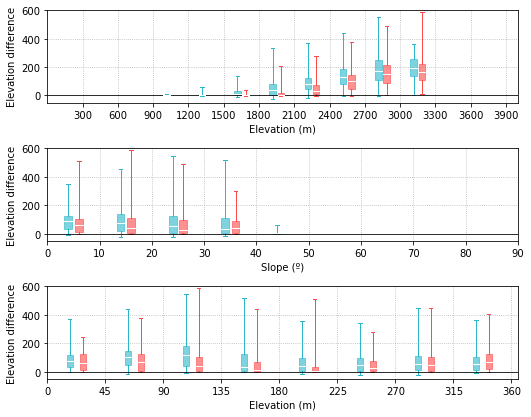

In [49]:
bin_elev_edges = np.arange(300,4000,300)
bin_aspect_edges = np.arange(0,370,45)
bin_slope_edges = np.arange(0,91,10)

# Create the figure
fig = plt.figure(figsize=(19*inch2cm, 15*inch2cm))

########################
# subplot 1 - boxplot = f( elevation )
ax = plt.subplot(311)
# dh_1
data_grouped = dh_1.groupby_bins( 'Z', bin_elev_edges)
boxplot_data, bin2plot = get_group_values( data_grouped, 30 )

# whis controls the extent of the whiskers, (0,100) shows the min-max extent
bp_1 = ax.boxplot(boxplot_data, positions=np.array(bin2plot)+35, widths=55, patch_artist=True, whis= (0, 100), showfliers=False,
            boxprops = { "facecolor":c1, "color":c1, "alpha":0.6},
            capprops = { "color":c1},
            whiskerprops = { "color":c1},
            medianprops = { "color":"w"},
            )

# dh_2
data_grouped = dh_2.groupby_bins( 'Z', bin_elev_edges)
boxplot_data, bin2plot = get_group_values( data_grouped, 30 )

# Create the boxplot
bp_2 = ax.boxplot(boxplot_data, positions=np.array(bin2plot)-35, widths=55, patch_artist=True, whis=(0, 100), showfliers=False,
            boxprops = { "facecolor":c2, "color":c2, "alpha":0.6},
            capprops = { "color":c2},
            whiskerprops = { "color":c2},
            medianprops = { "color":"w"},
            )

plt.grid(True,ls=":")
plt.xticks(bin_elev_edges, bin_elev_edges)
plt.hlines(0,0,4000, lw=0.8, color="k")
plt.axis((0,4000,-50,600))
ax.set_xlabel('Elevation (m)')
ax.set_ylabel('Elevation difference')


########################
# subplot 2 - boxplot = f( slope )
ax = plt.subplot(312)
# dh_1
data_grouped = dh_1.groupby_bins( 'SLP', bin_slope_edges)
boxplot_data, bin2plot = get_group_values( data_grouped, 30 )

# Create the boxplot
# whis controls the extent of the whiskers, (0,100) shows the min-max extent
bp_1 = ax.boxplot(boxplot_data, positions=np.array(bin2plot)+1, widths=1.5, patch_artist=True, whis= (0, 100), showfliers=False,
            boxprops = { "facecolor":c1, "color":c1, "alpha":0.6},
            capprops = { "color":c1},
            whiskerprops = { "color":c1},
            medianprops = { "color":"w"},
            )

# dh_2
data_grouped = dh_2.groupby_bins( 'SLP', bin_slope_edges)
boxplot_data, bin2plot = get_group_values( data_grouped, 30 )

# Create the boxplot
bp_2 = ax.boxplot(boxplot_data, positions=np.array(bin2plot)-1, widths=1.5, patch_artist=True, whis=(0, 100), showfliers=False,
            boxprops = { "facecolor":c2, "color":c2, "alpha":0.6},
            capprops = { "color":c2},
            whiskerprops = { "color":c2},
            medianprops = { "color":"w"},
            )

plt.grid(True,ls=":")
plt.xticks(bin_slope_edges, bin_slope_edges)
plt.hlines(0,0,90, lw=0.8, color="k")
plt.axis((0,90,-50,600))
ax.set_xlabel('Slope (º)')
ax.set_ylabel('Elevation difference')


########################
# subplot 3 - boxplot = f( aspect )
ax = plt.subplot(313)
# dh_1
data_grouped = dh_1.groupby_bins( 'ASP', bin_aspect_edges)
boxplot_data, bin2plot = get_group_values( data_grouped, 30 )

# Create the boxplot
# whis controls the extent of the whiskers, (0,100) shows the min-max extent
bp_1 = ax.boxplot(boxplot_data, positions=np.array(bin2plot)+5, widths=5, patch_artist=True, whis= (0, 100), showfliers=False,
            boxprops = { "facecolor":c1, "color":c1, "alpha":0.6},
            capprops = { "color":c1},
            whiskerprops = { "color":c1},
            medianprops = { "color":"w"},
            )

# dh_2
data_grouped = dh_2.groupby_bins( 'ASP', bin_aspect_edges)
boxplot_data, bin2plot = get_group_values( data_grouped, 30 )

# Create the boxplot
bp_2 = ax.boxplot(boxplot_data, positions=np.array(bin2plot)-5, widths=5, patch_artist=True, whis=(0, 100), showfliers=False,
            boxprops = { "facecolor":c2, "color":c2, "alpha":0.6},
            capprops = { "color":c2},
            whiskerprops = { "color":c2},
            medianprops = { "color":"w"},
            )

plt.grid(True,ls=":")
plt.xticks(bin_aspect_edges, bin_aspect_edges)
plt.hlines(0,0,365, lw=0.8, color="k")
plt.axis((0,365,-50,600))
ax.set_xlabel('Aspect (º)')
ax.set_ylabel('Elevation difference')

plt.tight_layout()
#plt.savefig("path/to/fig.png") # use .svg to further edit in svg 